## Variant Calling Report v1.2.6
## 1. Input Parameters

In [11]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
import nexusplt as nxp
from configparser import ConfigParser

pd.options.display.float_format = '{:,.2%}'.format
pd.set_option('display.max_colwidth', None)

In [12]:
configFile='var_report.config'
parser = ConfigParser()
parser.read(configFile)

prmNames=['run_id','pipeline_version', 
          'h5_concordance_file', 'h5_model_file', 
          'model_name_with_gt','model_name_without_gt',
          'model_pkl_with_gt','model_pkl_without_gt'
         ]

prm={}
for name in prmNames:
    prm[name]=parser.get('VarReport', name)

h5outfile = parser.get('VarReport', 'h5_output', fallback='var_report.h5')
imgpref = parser.get('VarReport', 'image_output_prefix', fallback=prm['run_id']+'.vars')+'.'
reference_version = parser.get('VarReport', 'reference_version', fallback='hg38')
prm['reference_version'] = reference_version
imgdir = 'plots'

sources = {'Trained wo gt':(prm['h5_concordance_file'],"concordance"),
           'Trained with gt':(prm['h5_model_file'],"scored_concordance"),
          }

data = {}

if reference_version == "hg38":
    columns_to_select = ['indel','hmer_indel_length', 'tree_score',
                     'filter','blacklst', 'classify','classify_gt',
                     'indel_length','hmer_indel_nuc','ref',
                     'gt_ground_truth','well_mapped_coverage','mappability.0','ug_hcr','LCR-hs38']
    rename_dict = {'LCR-hs38':'LCR'}
elif reference_version == "hg19":
        columns_to_select = ['indel','hmer_indel_length', 'tree_score',
                         'filter','blacklst', 'classify','classify_gt',
                         'indel_length','hmer_indel_nuc','ref',
                         'gt_ground_truth','well_mapped_coverage', 'LCR-hg19_tab_no_chr', 'mappability.hg19.0_tab_no_chr','ug_hcr_hg19_no_chr']
        rename_dict = {'LCR-hg19_tab_no_chr':'LCR', 
                       'mappability.hg19.0_tab_no_chr':'mappability.0',
                       'ug_hcr_hg19_no_chr':'ug_hcr'}
for s in sources:
    data[s]={}
    d=pd.read_hdf(sources[s][0], key=sources[s][1], mode='r')
    data[s]=d.rename(columns=rename_dict)

# Load the concordance data for the entire genome
with pd.HDFStore(prm['h5_concordance_file']) as hdf:
    keys=hdf.keys()
    wg_dfs=[pd.read_hdf(hdf,k) for k in keys if k not in ['/concordance','/input_args']]
    wg_dfs = [ w[[ x for x in columns_to_select if x in w.columns]] for w in wg_dfs]
    wg_df=pd.concat(wg_dfs)
    wg_df.rename(columns=rename_dict,inplace=True)
    
data['whole genome'] = wg_df
sources['whole genome'] = (prm['h5_concordance_file'],"all")
   
if 'well_mapped_coverage' in data['whole genome'].columns:
    prm['mean_var_depth']='{:.2f}'.format(data['Trained wo gt']['well_mapped_coverage'].mean())
    prmNames.append('mean_var_depth')
  
try:
    args=pd.read_hdf(sources['Trained wo gt'][0], 'input_args', mode='r')
    prm['truth_sample_name']=args['truth_sample_name'][0]
except:
    prm['truth_sample_name']=parser.get('VarReport', 'truth_sample_name', fallback='NA')
prmNames.append('truth_sample_name')


prmdf = pd.DataFrame.from_dict(prm, orient='index',columns=['value']).reindex(prmNames)
prmdf.to_hdf(h5outfile, key="parameters")

prmdf



,value
run_id,140479-BC21
pipeline_version,2.4.1
h5_concordance_file,./test.untrained.h5
h5_model_file,./test.trained.h5
reference_version,hg38
model_name_with_gt,untrained_ignore_gt_excl_hpol_runs
model_name_without_gt,threshold_model_recall_precision_ignore_gt_excl_hpol_runs
model_pkl_with_gt,dummy1.pkl
model_pkl_without_gt,dummy2.pkl
mean_var_depth,64.32


In [13]:
def filterByCategory(data,cat):
    if cat=='SNP':
        return data[data['indel']==False]
    if cat=='Indel':
        return data[data['indel']==True]
    elif cat=='non-hmer Indel':
        return data[(data['indel']==True) & (data['hmer_indel_length']==0) & (data['indel_length']>0)]
    elif cat=='non-hmer Indel w/o LCR':
        return data[(data['indel']==True) & (data['hmer_indel_length']==0) & (data['indel_length']>0) & 
                (~data['LCR'])]
    elif cat=='hmer Indel <=4':
        return data[(data['indel']==True) & (data['hmer_indel_length']>0) & (data['hmer_indel_length']<=4)]
    elif cat=='hmer Indel >4,<=8':
        return data[(data['indel']==True) & (data['hmer_indel_length']>4) & (data['hmer_indel_length']<=8)]
    elif cat=='hmer Indel >8,<=10':
        return data[(data['indel']==True) & (data['hmer_indel_length']>8) & (data['hmer_indel_length']<=10)]
    for i in range (1,10):
        if cat=='hmer Indel {0:d}'.format(i):
            return data[(data['indel']==True) & (data['hmer_indel_length']==i)]
    return None


In [14]:
def calcPerformance(data):
    classify_col='classify_gt' 
    d=data.copy()
    
    # Calculate precision and recall continuously along the tree_score values
    d['tree_score'] = np.where(d[classify_col]=='fn',-1,d['tree_score'])
    d=d[[classify_col,'tree_score','filter']].sort_values(by=['tree_score'])
    
    d['label'] = np.where(d[classify_col]=='fp',0,1)

    d.loc[d['filter']=='HPOL_RUN','filter']='PASS'
    d.loc[d[classify_col]=='fn','filter']='MISS'

    num=len(d)
    numPos=sum(d['label'])
    numNeg=num-numPos
    if num<10:
        return (pd.DataFrame(),None,numPos,numNeg)
    
    d['fn']=np.cumsum(d['label'])
    d['tp']=numPos-(d['fn'])
    d['fp']=numNeg-np.cumsum(1-d['label'])

    d['recall']=d['tp']/(d['tp']+d['fn'])
    d['precision']=d['tp']/(d['tp']+d['fp'])

    d['f1']=d['tp']/(d['tp']+0.5*d['fn']+0.5*d['fp'])

    d['mask']=((d['tp']+d['fn'])>=20) & ((d['tp']+d['fp'])>=20) & (d['tree_score']>=0)
    if len(d[d['mask']])==0:
        return (pd.DataFrame(),None,numPos,numNeg)

    # Calculate the precision and recall as ouputted by the model (based on the FILTER column)
    d['class'] = np.where(d['label']==0,'FP','FN')
    d.loc[(d['label']==1) & (d['filter']=='PASS'),'class']='TP'
    d.loc[(d['label']==0) & (d['filter']!='PASS'),'class']='TN'

    fn=len(d[d['class']=='FN'])
    tp=len(d[d['class']=='TP'])
    fp=len(d[d['class']=='FP'])

    recall=tp/(tp+fn) if (tp+fn>0) else np.nan
    precision=tp/(tp+fp) if (tp+fp>0) else np.nan
    max_recall=1-len(d[d['filter']=='MISS'])/numPos

    f1=tp/(tp+0.5*fn+0.5*fp)
    
    return (d[['recall','precision']][d['mask']],
            dict({'recall':recall,'precision':precision,'f1':f1}),
            numPos,numNeg)



In [15]:
def plotPerformance(perfCurve,optRes,categories,source=sources,ext=None,img=None,legend=None,optRes_SEC=None):
    n=len(categories)
    nrow=int(np.ceil(n/5))
    ncol=int(max(5,n))
    fig, ax = plt.subplots(1,n,figsize=(4*n,4))
    #fig, ax = plt.subplots(1,ncol) #figsize=(4*nrow,4*ncol)
    #ax=ax.flatten()
    
    col=['r','b','g','m','k']

    for i,cat in enumerate(categories):
        for j,s in enumerate(source):
            perf=perfCurve[s][cat]
            opt=optRes[s][cat]
            if optRes_SEC is not None:
                opt_sec=optRes_SEC[s][cat]
            if not perf.empty:
                ax[i].plot(perf.recall,perf.precision,'-',label=s,color=col[j])    
                ax[i].plot(opt.get('recall'),opt.get('precision'),'o',color=col[j])
                if optRes_SEC is not None:
                    ax[i].plot(opt_sec.get('recall'),opt_sec.get('precision'),'o',color="black")
            title=cat if ext==None else '{0} ({1})'.format(cat,ext)
            ax[i].set_title(title)
            ax[i].set_xlabel("Recall")
            ax[i].set_xlim([0.4,1])
            ax[i].set_ylim([0.4,1])
            ax[i].grid(True)

    ax[0].set_ylabel("Precision")
    if legend: 
        ax[0].legend(loc='lower left')    
    if img:
        nxp.save(fig,imgpref+img,'png',outdir=imgdir)
    
    
def getPerformance(data,categories):
    optTab={}
    optRes={}
    perfCurve={}
    for s in sources:
        optTab[s]=pd.DataFrame()
        optRes[s]={}
        perfCurve[s]={}

        for i,cat in enumerate(categories):
            d=filterByCategory(data[s],cat)
            perf,opt,pos,neg=calcPerformance(d)
            perfCurve[s][cat]=perf
            optRes[s][cat]=opt
            
            row=pd.DataFrame({'# pos':pos,
                              '# neg':neg,
                              'max recall':np.nan if perf.empty else max(perf.recall),
                              'recall':np.nan if perf.empty else opt.get('recall'),
                              'precision':np.nan if perf.empty else opt.get('precision'),
                              'F1':np.nan if perf.empty else opt.get('f1')
                             },index=[cat])
            optTab[s]=pd.concat([optTab[s],row])
            
    return optTab,optRes,perfCurve

## 2. Performance over all Data
The concordance between the variant calling results and the ground truth sample is presented below.
* Red line - precision and recall over different tree-scores.
* Red dot - precision and recall values for the chosen threshold.
* Black dot -precision and recall after filtering systematic errors (SEC)

In [16]:
def has_sec(x):
    res = False
    if x is not None:
        if x==x:
            if "SEC" in x:
                res=True
    return res

sec_df = data['whole genome'].copy()
data_SEC={}
if 'blacklst' in sec_df.columns:
    is_sec = sec_df['blacklst'].apply(has_sec)
    sec_df.loc[is_sec,'filter'] = "SEC"
    sec_df.loc[(is_sec) & (sec_df['classify_gt']=='tp'),'classify_gt'] = "fn"
    sec_df_new=sec_df[~((is_sec) & (sec_df['classify_gt']=='fp'))]
    data_SEC={'whole genome': sec_df_new,'Trained wo gt':data['Trained wo gt'].copy(), 'Trained with gt':data['Trained with gt'].copy()}

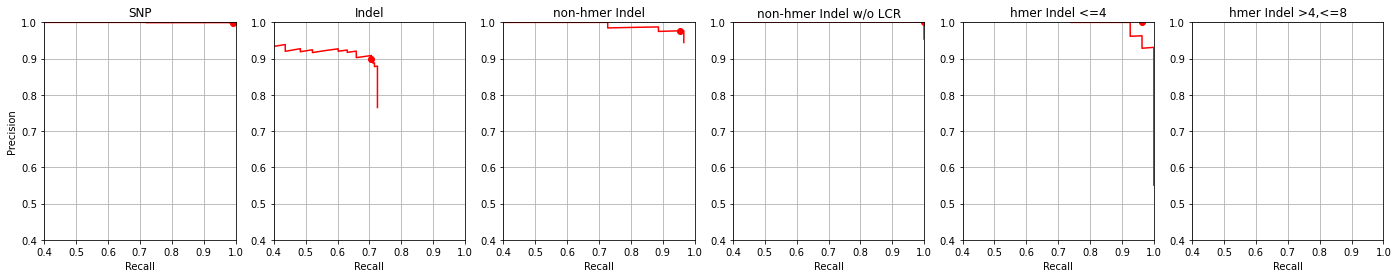

In [17]:
categories=['SNP','Indel','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(data,categories)
if data_SEC :
    SEC_optTab1,SEC_optRes,SEC_perfCurve=getPerformance(data_SEC,categories)
    plotPerformance(perfCurve,optRes,categories,img='all.primary',source={'whole genome':sources['whole genome']},optRes_SEC=SEC_optRes)
else:
    plotPerformance(perfCurve,optRes,categories,img='all.primary',source={'whole genome':sources['whole genome']})

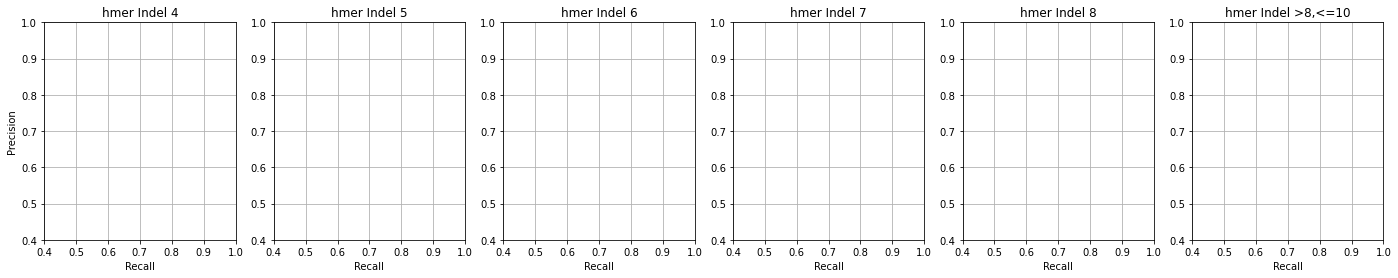

In [18]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=10']
optTab2,optRes,perfCurve=getPerformance(data,categories)
if data_SEC :
    SEC_optTab2,SEC_optRes,SEC_perfCurve=getPerformance(data_SEC,categories)
    plotPerformance(perfCurve,optRes,categories,img='all.primary',source={'whole genome':sources['whole genome']},optRes_SEC=SEC_optRes)
else:
    plotPerformance(perfCurve,optRes,categories,img='all.primary',source={'whole genome':sources['whole genome']})

In [19]:
pd.options.display.float_format = '{:,.2%}'.format

optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])

df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="all_data")

if data_SEC :
    df_SEC=pd.concat([SEC_optTab1['whole genome'],SEC_optTab2['whole genome']])
    df_SEC.to_hdf(h5outfile, key="sec_data")
    display(pd.concat([df['whole genome'],df_SEC], keys=['Whole genome','After filtering systematic errors'], axis=1))
else:
    display(df['whole genome'])

,# pos,# neg,max recall,recall,precision,F1
SNP,1726,15,99.25%,99.19%,99.71%,99.45%
Indel,211,48,72.51%,70.62%,89.76%,79.05%
non-hmer Indel,88,6,96.59%,95.45%,97.67%,96.55%
non-hmer Indel w/o LCR,63,4,100.00%,100.00%,100.00%,100.00%
hmer Indel <=4,27,23,100.00%,96.30%,100.00%,98.11%
"hmer Indel >4,<=8",17,5,NaN,NaN,NaN,NaN
hmer Indel 4,4,2,NaN,NaN,NaN,NaN
hmer Indel 5,6,2,NaN,NaN,NaN,NaN
hmer Indel 6,3,2,NaN,NaN,NaN,NaN
hmer Indel 7,2,1,NaN,NaN,NaN,NaN


### 2.1 Homozygous genotyping accuracy

The precision and recall of called homozygous variants (where the variant was not classfied as False Negative)

In [20]:
categories=['SNP','Indel','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']

hmzData={}
for s in sources:
        d=data[s]
        hmzData[s]=d[(d['gt_ground_truth']==(1,1)) & (d['classify']!='fn')]
optTab,optRes,perfCurve=getPerformance(hmzData,categories)
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="all_data_homozygous")

display(df['whole genome'])

,# pos,# neg,max recall,recall,precision,F1
SNP,764,0,99.74%,99.87%,100.00%,99.93%
Indel,60,0,98.33%,100.00%,100.00%,100.00%
non-hmer Indel,33,0,96.97%,100.00%,100.00%,100.00%
non-hmer Indel w/o LCR,27,0,96.30%,100.00%,100.00%,100.00%
hmer Indel <=4,10,0,NaN,NaN,NaN,NaN
"hmer Indel >4,<=8",9,0,NaN,NaN,NaN,NaN


### 2.2 Stratified by base

#### (A,T)

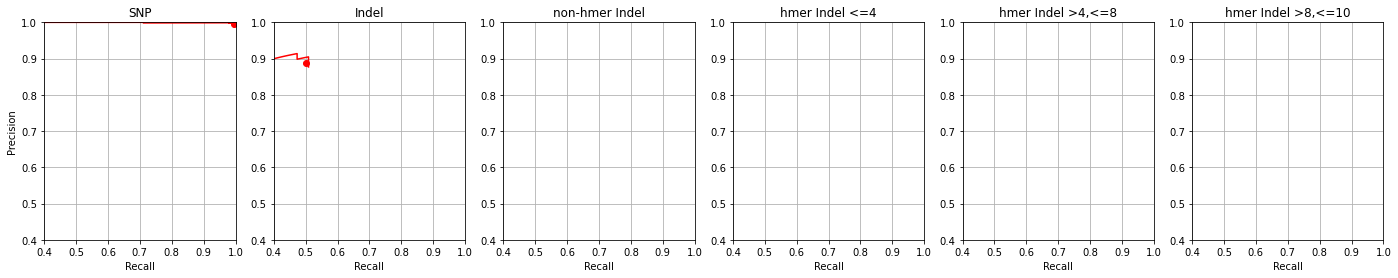

In [21]:
categories=['SNP','Indel','non-hmer Indel','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=10']

baseData={}
b =('A','T')
for s in sources:
        d=data[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab1,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab1[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab1[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,source={'whole genome':sources['whole genome']})

#### (G,C)

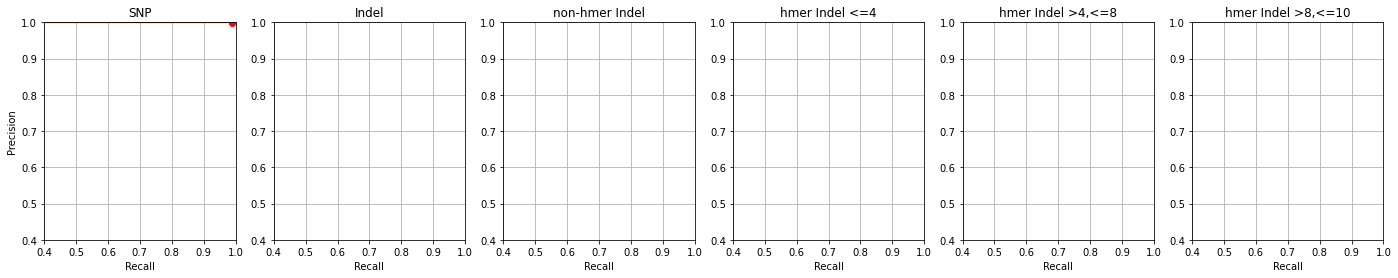

In [22]:
categories=['SNP','Indel','non-hmer Indel','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=10']
baseData={}
b =('C','G')
for s in sources:
        d=data[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab2,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab2[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab2[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,source={'whole genome':sources['whole genome']})

In [23]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="all_data_per_base")
df['whole genome']

,# pos,# neg,max recall,recall,precision,F1
SNP (A/T),855,11,99.42%,99.42%,99.65%,99.53%
Indel (A/T),112,9,50.89%,50.00%,88.89%,64.00%
non-hmer Indel (A/T),0,0,NaN,NaN,NaN,NaN
hmer Indel <=4 (A/T),19,0,NaN,NaN,NaN,NaN
"hmer Indel >4,<=8 (A/T)",15,3,NaN,NaN,NaN,NaN
"hmer Indel >8,<=10 (A/T)",12,2,NaN,NaN,NaN,NaN
SNP (C/G),871,4,99.08%,98.97%,99.77%,99.37%
Indel (C/G),11,26,NaN,NaN,NaN,NaN
non-hmer Indel (C/G),0,0,NaN,NaN,NaN,NaN
hmer Indel <=4 (C/G),8,23,NaN,NaN,NaN,NaN


## 3. Performance over UG high confidence regions

Variant calling peformance exclusing genomic areas where UG performance is poor, i.e:
- Homopolymers - runs of length 11 bp and above, padded with four bases around the genomic coordinates,
- AT-rich regions - bases where the GC content of the surrounding 40 bases is lower than 5%,
- Tandem repeats,
- Low mapping quality - regions that are covered by at least 20 reads, but less than 10% of these reads are aligned with mapping quality > 20,
- High coverage variability - regions with coverage that is highly variable between samples (std/mean > 0.5)

In [24]:
filtData={}
for s in sources:
    d=data[s]
    if s == 'whole genome':
        filtData[s]=d.query("ug_hcr==True").copy()
    else:
        filtData[s]=d.copy()


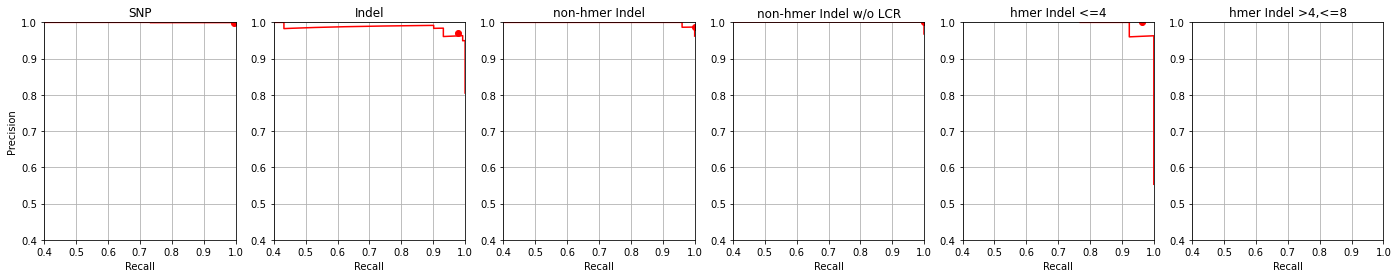

In [25]:
categories=['SNP','Indel','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories,img='hicvg.primary',source={'whole genome':sources['whole genome']})

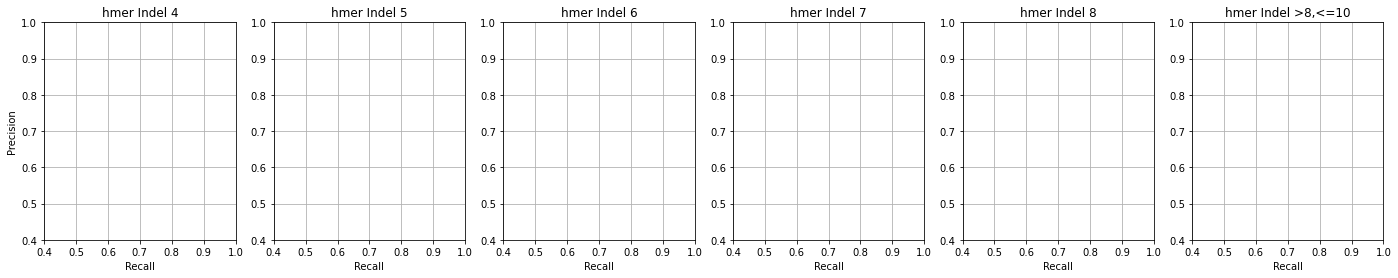

In [26]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=10']
optTab2,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories,img='hicvg.hmers',source={'whole genome':sources['whole genome']})

In [27]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="ug_hcr")
defTable=df.copy()
df['whole genome']

,# pos,# neg,max recall,recall,precision,F1
SNP,1697,11,99.71%,99.65%,99.94%,99.79%
Indel,132,33,100.00%,97.73%,96.99%,97.36%
non-hmer Indel,76,4,100.00%,100.00%,98.70%,99.35%
non-hmer Indel w/o LCR,60,3,100.00%,100.00%,100.00%,100.00%
hmer Indel <=4,26,22,100.00%,96.15%,100.00%,98.04%
"hmer Indel >4,<=8",17,5,NaN,NaN,NaN,NaN
hmer Indel 4,4,2,NaN,NaN,NaN,NaN
hmer Indel 5,6,2,NaN,NaN,NaN,NaN
hmer Indel 6,3,2,NaN,NaN,NaN,NaN
hmer Indel 7,2,1,NaN,NaN,NaN,NaN


### 3.1 Homozygous genotyping accuracy

In [28]:
categories=['SNP','Indel','non-hmer Indel','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=10']

hmzData={}
for s in sources:
        d=filtData[s]
        hmzData[s]=d[(d['gt_ground_truth']==(1,1)) & (d['classify']!='fn')]
optTab,optRes,perfCurve=getPerformance(hmzData,categories)
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="ug_hcr_homozygous")
df['whole genome']

,# pos,# neg,max recall,recall,precision,F1
SNP,750,0,99.73%,99.87%,100.00%,99.93%
Indel,55,0,98.18%,100.00%,100.00%,100.00%
non-hmer Indel,32,0,96.88%,100.00%,100.00%,100.00%
hmer Indel <=4,10,0,NaN,NaN,NaN,NaN
"hmer Indel >4,<=8",9,0,NaN,NaN,NaN,NaN
"hmer Indel >8,<=10",4,0,NaN,NaN,NaN,NaN


## 4. Performance over regions with coverage>=20 and excluding areas with mappability

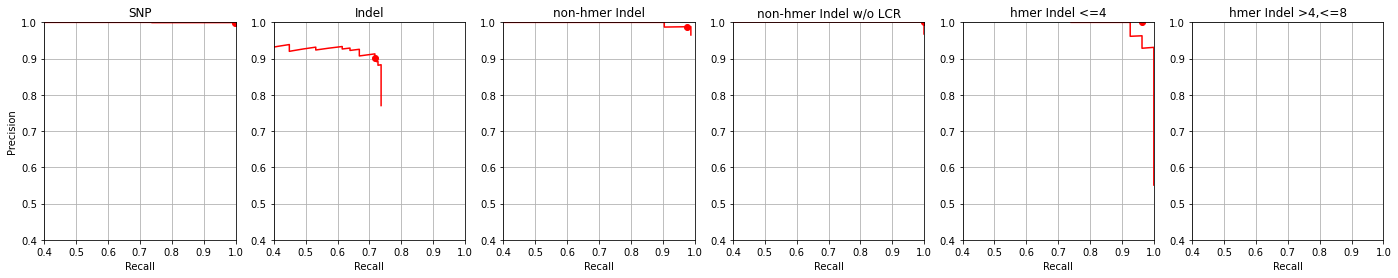

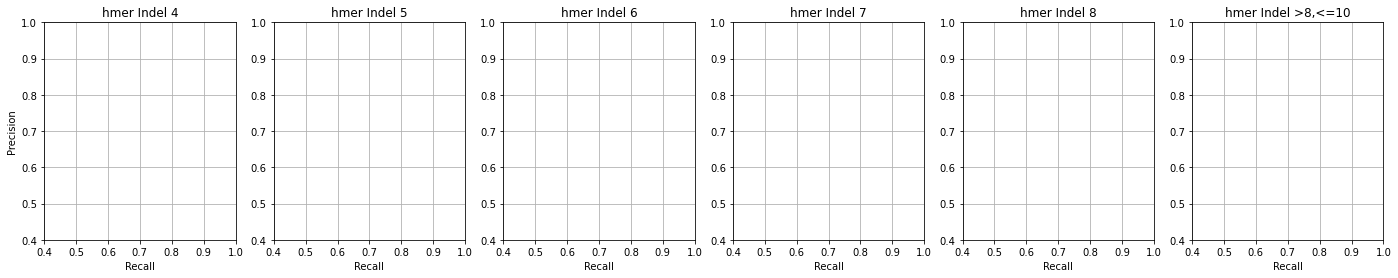

In [29]:
if 'well_mapped_coverage' in data['whole genome'].columns:
    filtData={}
    for s in sources:
        d=data[s]
        filtData[s]=d[(d['well_mapped_coverage']>=20) &
                      (d['mappability.0'])
                     ]
    categories=['SNP','Indel','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
    optTab1,optRes,perfCurve=getPerformance(filtData,categories)
    plotPerformance(perfCurve,optRes,categories,img='hicvg.primary',source={'whole genome':sources['whole genome']})


    categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=10']
    optTab2,optRes,perfCurve=getPerformance(filtData,categories)
    plotPerformance(perfCurve,optRes,categories,img='hicvg.hmers',source={'whole genome':sources['whole genome']})

    optTab={}
    for s in sources:
        optTab[s]=pd.concat([optTab1[s], optTab2[s]])
    df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
    df.to_hdf(h5outfile, key="good_cvg_data")
    defTable=df.copy()
    df['whole genome']
else:
    print("No coverage data available")

### 4.1 Homozygous genotyping accuracy

In [30]:
categories=['SNP','Indel','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']

hmzData={}
for s in sources:
        d=filtData[s]
        hmzData[s]=d[(d['gt_ground_truth']==(1,1)) & (d['classify_gt']!='fn')]
optTab,optRes,perfCurve=getPerformance(hmzData,categories)
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data_homozygous")
df['whole genome']

,# pos,# neg,max recall,recall,precision,F1
SNP,750,0,99.87%,100.00%,100.00%,100.00%
Indel,59,0,98.31%,100.00%,100.00%,100.00%
non-hmer Indel,32,0,96.88%,100.00%,100.00%,100.00%
non-hmer Indel w/o LCR,26,0,96.15%,100.00%,100.00%,100.00%
hmer Indel <=4,10,0,NaN,NaN,NaN,NaN
"hmer Indel >4,<=8",9,0,NaN,NaN,NaN,NaN


##  5. Trained with and without Ground Truth

<ul>
<li><b>Trained wo gt - Trained without ground truth </b></li>
Random forest model trained on chromosome 9 using known variants in dbSNP and on common fp variants
<li><b>Trained with gt - Trained with ground truth</b></li>
Simple threshold model trained on chromosome 9 using its own ground truth
</ul>

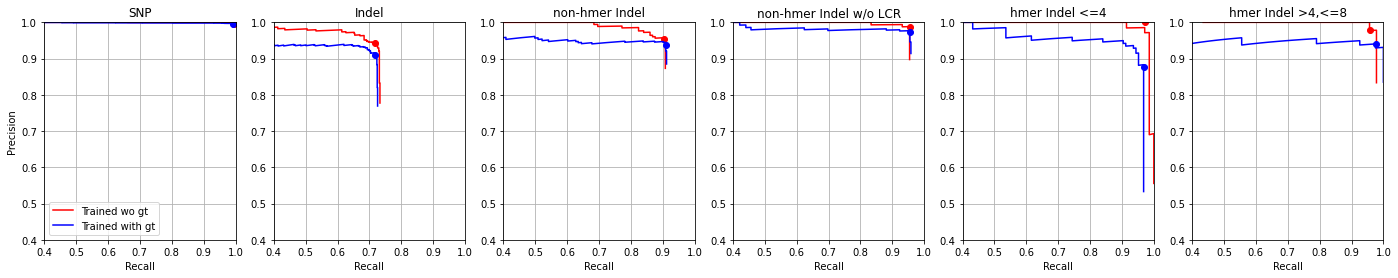

In [31]:
categories=['SNP','Indel','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(data,categories)
plotPerformance(perfCurve,optRes,categories,img='all.primary',source={'Trained wo gt':sources['Trained wo gt'], 'Trained with gt': sources['Trained wo gt']},legend=sources[s])

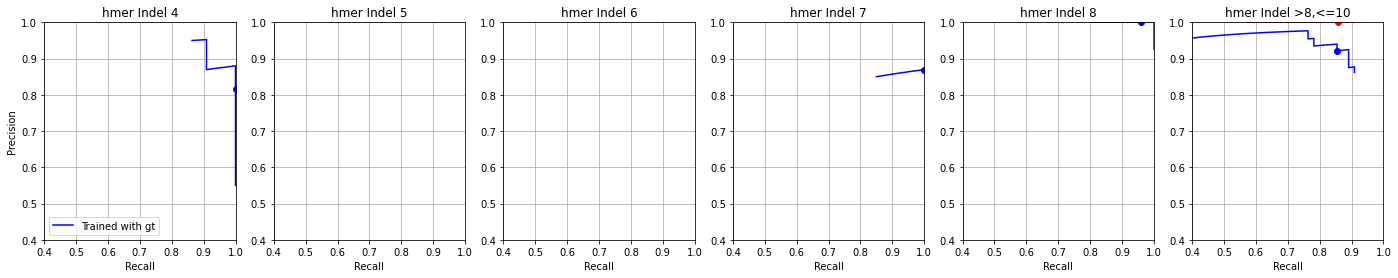

In [32]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=10']
optTab2,optRes,perfCurve=getPerformance(data,categories)
plotPerformance(perfCurve,optRes,categories,img='all.hmers',source={'Trained wo gt':sources['Trained wo gt'], 'Trained with gt': sources['Trained wo gt']},legend=sources[s])

In [33]:
pd.options.display.float_format = '{:,.2%}'.format
sources={'Trained wo gt':sources['Trained wo gt'], 'Trained with gt': sources['Trained wo gt']}
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="trained_w_wo_gt")
df_all=df
df

Trained wo gt                                           \
                               # pos # neg max recall recall precision     F1   
SNP                             4307    35     99.61% 99.58%    99.51% 99.55%   
Indel                            543   115     73.30% 71.82%    94.43% 81.59%   
non-hmer Indel                   250    34     90.80% 90.40%    95.36% 92.81%   
non-hmer Indel w/o LCR           174    20     95.40% 95.40%    98.81% 97.08%   
hmer Indel <=4                    70    57    100.00% 97.14%   100.00% 98.55%   
hmer Indel >4,<=8                 46    10     97.83% 95.65%    97.78% 96.70%   
hmer Indel 4                       6     9        NaN    NaN       NaN    NaN   
hmer Indel 5                      11     4        NaN    NaN       NaN    NaN   
hmer Indel 6                      13     3        NaN    NaN       NaN    NaN   
hmer Indel 7                      11     3        NaN    NaN       NaN    NaN   
hmer Indel 8                      11     0        NaN    NaN       NaN    NaN   
hmer Indel >8,<=10                35     0     91.43% 85.71%   100.00% 92.31%   

                       Trained with gt                                     \
                                 # pos # neg max recall  recall precision   
SNP                               6838    65     99.39%  99.25%    99.46%   
Indel                              900   197     72.56%  71.89%    91.13%   
non-hmer Indel                     397    48     91.18%  90.93%    93.77%   
non-hmer Indel w/o LCR             311    29     95.82%  95.50%    97.38%   
hmer Indel <=4                     125   107     96.80%  96.80%    87.68%   
hmer Indel >4,<=8                   81    17    100.00%  97.53%    94.05%   
hmer Indel 4                        22    19    100.00% 100.00%    81.48%   
hmer Indel 5                        18     7        NaN     NaN       NaN   
hmer Indel 6                        18     3        NaN     NaN       NaN   
hmer Indel 7                        20     4    100.00% 100.00%    86.96%   
hmer Indel 8                        25     3    100.00%  96.00%   100.00%   
hmer Indel >8,<=10                  55     9     90.91%  85.45%    92.16%   

                               
                           F1  
SNP                    99.36%  
Indel                  80.37%  
non-hmer Indel         92.33%  
non-hmer Indel w/o LCR 96.43%  
hmer Indel <=4         92.02%  
hmer Indel >4,<=8      95.76%  
hmer Indel 4           89.80%  
hmer Indel 5              NaN  
hmer Indel 6              NaN  
hmer Indel 7           93.02%  
hmer Indel 8           97.96%  
hmer Indel >8,<=10     88.68%

In [34]:
%matplotlib agg
d=defTable['Trained with gt'][['max recall','recall','precision']]
labels=['SNP','Indel','nhmer','nhmer w/o LCR','hmer 2-4','hmer 5-8','hmer 4','hmer 5','hmer 6','hmer 7','hmer 8','hmer 9-10']
fig=plt.figure()
ax=d.plot()
plt.xticks(np.arange(len(d.index)), rotation=30, ha='right')
ax.set_xticklabels(labels)
plt.ylim([0.4,1.05])
plt.grid()
plt.title('Cvg>20X, Trained variant calls')
plt.tight_layout()
nxp.save(fig,imgpref+'summary','png',outdir=imgdir)
plt.close(fig)